**3/11/21**

The purpose of this notebook is to compare the spectra identified by the 16S_Sample-Matched, Shotgun_Sample-Matched, and Shotgun_Pooled databases to see how much overlap there is and determine whether there could be any complementarity between the different approaches.

In [1]:
from elliot_utils import *

In [2]:
analysisPath = Path.cwd().joinpath('analysis_files/metagenomic_analysis/')
figPath = Path.cwd().joinpath('figures/metagenomic_analysis/')

In [3]:
tailoredResults = getOrderedFiles(TAILORED_RESULTS, '.tsv')
individualResults = getOrderedFiles(SINGLE_RESULTS, '.tsv')
combinedResults = getOrderedFiles(POOLED_RESULTS, '.tsv')

In [4]:
# Get filtered bacterial peptides for each database search
tailoredAllowedPeps = getFilteredPeptides(tailoredResults, 'bacteria')
combinedAllowedPeps = getFilteredPeptides(combinedResults, 'bacteria')
individualAllowedPeps = getFilteredPeptides(individualResults, 'bacteria')

First, I'm interested in how many of the total "possible to identify" spectra each database search successfully identifies. I'll consider the total universe of spectra that it is possible to identify as all spectra in each sample identified by at least one of the database searches.

In [5]:
# For each sample, get a set of all Spectrum ID's that were identified by one of the three database searches.
# Also get the set of spectra each search identified

# Add the bacterial spectra identified in the result file to set1 and set2
def addSpectraToSets(result, allowedPeps, set1, set2):
    with result.open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            if not isSignificant(row):
                break
            if protType == 'bacteria' and row[PEPTIDE] in allowedPeps:
                set1.add(row[SPEC_ID])
                set2.add(row[SPEC_ID])

In [6]:
spectraHolder = {'All':[], '16S_Sample-Matched':[], 'Shotgun_Pooled':[], 'Shotgun_Sample-Matched':[]}
for i in range(len(SAMPLE_NAMES)):
    for setList in spectraHolder.values():
        setList.append(set())
    addSpectraToSets(tailoredResults[i], tailoredAllowedPeps, spectraHolder['All'][i], spectraHolder['16S_Sample-Matched'][i])
    addSpectraToSets(combinedResults[i], combinedAllowedPeps, spectraHolder['All'][i], spectraHolder['Shotgun_Pooled'][i])
    addSpectraToSets(individualResults[i], individualAllowedPeps, spectraHolder['All'][i], spectraHolder['Shotgun_Sample-Matched'][i])

In [7]:
totalSpectraCounts = []
tailoredSpectraPercents = []
combinedSpectraPercents = []
individualSpectraPercents = []
for i in range(len(SAMPLE_NAMES)):
    totalSpectraCounts.append(len(spectraHolder['All'][i]))
    tailoredSpectraPercents.append(len(spectraHolder['16S_Sample-Matched'][i]) / totalSpectraCounts[i] * 100)
    combinedSpectraPercents.append(len(spectraHolder['Shotgun_Pooled'][i] )/ totalSpectraCounts[i] * 100)
    individualSpectraPercents.append(len(spectraHolder['Shotgun_Sample-Matched'][i]) / totalSpectraCounts[i] * 100)

In [8]:
dbLabels = []
dbLabels += ['16S_Sample-Matched' for x in range(len(SAMPLE_NAMES))]
dbLabels += ['Shotgun_Pooled' for x in range(len(SAMPLE_NAMES))]
dbLabels += ['Shotgun_Sample-Matched' for x in range(len(SAMPLE_NAMES))]

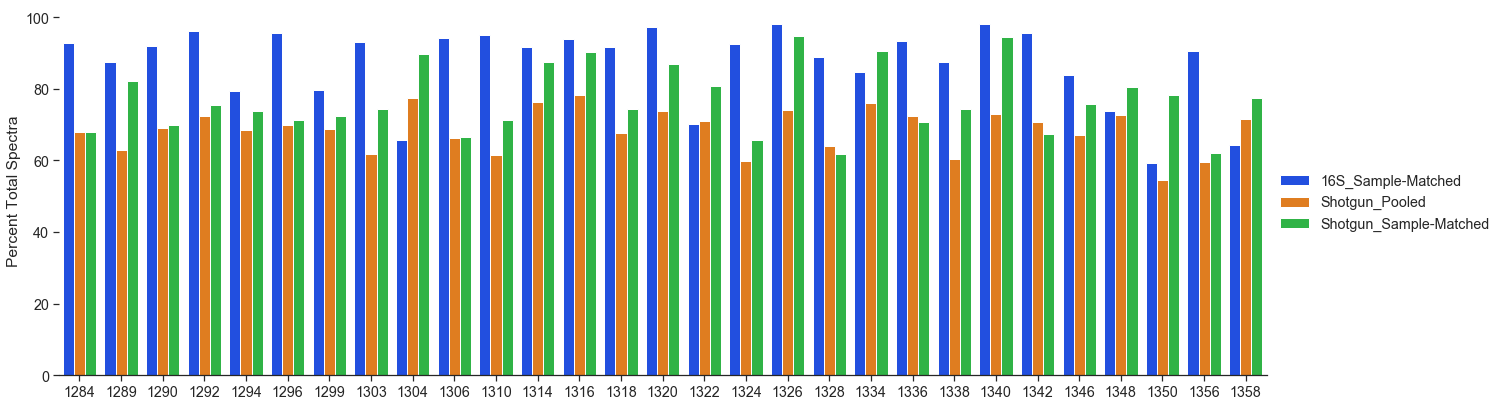

In [9]:
spectraPercentsDF = pd.DataFrame({'Percent Total Spectra':tailoredSpectraPercents + combinedSpectraPercents + individualSpectraPercents, 'Sample':SAMPLE_NAMES + SAMPLE_NAMES + SAMPLE_NAMES, '':dbLabels})
spectraPercentsGraph = sns.catplot(x='Sample', y='Percent Total Spectra', hue='', data=spectraPercentsDF, height=6, aspect=3, kind="bar")
spectraPercentsGraph.despine(left=True)
spectraPercentsGraph.set_xlabels('')

Of the bacterial spectra identified by the Tailored or Individual database searches, how much overlap is there?

In [10]:
# Returns a 2D list of percentages that correspond to [[sample1_db1Only, sample1_both, sample1_db2Only], ...]
def getComparisonData(holder, db1Name, db2Name):
    total = []
    both = []
    db1Only = []
    db2Only = []
    for i in range(len(SAMPLE_NAMES)):
        total.append(len(holder[db1Name][i].union(holder[db2Name][i])))
        both.append(len(holder[db1Name][i].intersection(holder[db2Name][i])) / total[i] * 100)
        db1Only.append(len(holder[db1Name][i].difference(holder[db2Name][i])) / total[i] * 100)
        db2Only.append(len(holder[db2Name][i].difference(holder[db1Name][i])) / total[i] * 100)
    toReturn = []
    for i in range(len(SAMPLE_NAMES)):
        toReturn.append([db1Only[i], both[i], db2Only[i]])
    return toReturn

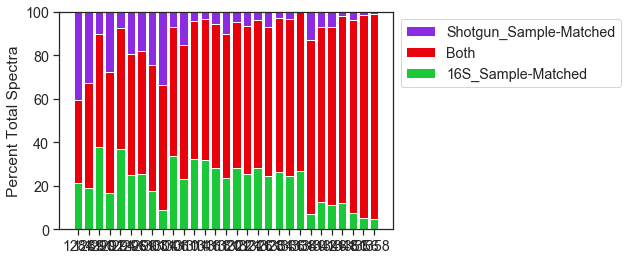

In [12]:
# Overlap between 16S_Sample-Matched and Shotgun_Sample-Matched
customColors = sns.color_palette('bright')[2:5]
tailind = getComparisonData(spectraHolder, '16S_Sample-Matched', 'Shotgun_Sample-Matched')
tailind.sort(key=lambda x:x[1])
generateNormalizedStackedBar(SAMPLE_NAMES, ['16S_Sample-Matched', 'Both', 'Shotgun_Sample-Matched'], tailind, title='', ylabel='Percent Total Spectra', colors=customColors, legendOrder=[2, 1, 0], savepath=figPath.joinpath('overlap_Tailored_Single.png'))

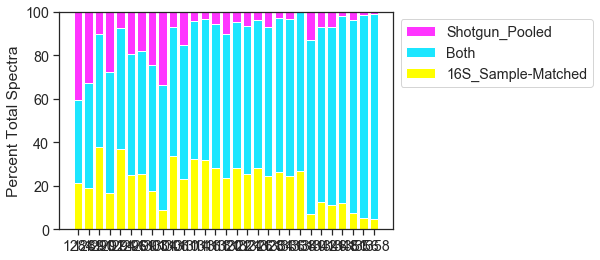

In [13]:
# Overlap between 16S_Sample-Matched and Shotgun_Pooled
tailcomb = getComparisonData(spectraHolder, '16S_Sample-Matched', 'Shotgun_Pooled')
generateNormalizedStackedBar(SAMPLE_NAMES, ['16S_Sample-Matched', 'Both', 'Shotgun_Pooled'], tailind, title='', ylabel='Percent Total Spectra', legendOrder=[2, 1, 0])

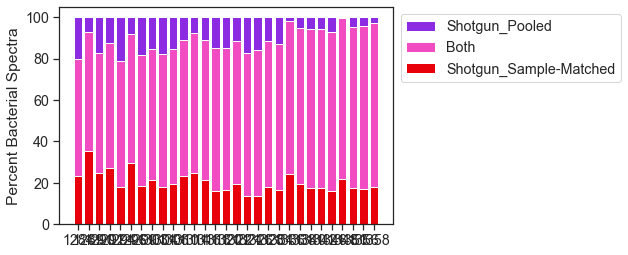

In [14]:
# Overlap between Shotgun_Sample-Matched and Shotgun_Pooled
customColors = [sns.color_palette('bright')[3], sns.color_palette('bright')[6], sns.color_palette('bright')[4]]
tailind = getComparisonData(spectraHolder, 'Shotgun_Sample-Matched', 'Shotgun_Pooled')
tailind.sort(key=lambda x:x[1])
generateNormalizedStackedBar(SAMPLE_NAMES, ['Shotgun_Sample-Matched', 'Both', 'Shotgun_Pooled'], tailind, title='', ylabel='Percent Bacterial Spectra', colors=customColors, savepath=figPath.joinpath('overlap_Single_Pooled.png'), legendOrder=[2, 1, 0])

In [15]:
tailoredAllowedHumanPeps = getFilteredPeptides(tailoredResults, 'human')
individualAllowedHumanPeps = getFilteredPeptides(individualResults, 'human')
tailoredAllowedBacteria = getFilteredPeptides(tailoredResults, 'bacteria')
singleAllowedBacteria = getFilteredPeptides(individualResults, 'bacteria')

In [24]:
# Returns a dictionary of specified spectra in the result file. key=spectra ID, value=spectrum object
def getResultSpectra(result, allowedPeps, typeOfProt):
    toReturn = {}
    with result.open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            if not isSignificant(row):
                break
            if protType == typeOfProt and row[PEPTIDE] in allowedPeps:
                toReturn[row[SPEC_ID]] = Spectrum(row)
    return toReturn

# Returns a dictionary of all spectra in the result file. key=spectra ID, value=spectrum object
def getAllSpectra(result):
    toReturn = {}
    with result.open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            toReturn[row[SPEC_ID]] = Spectrum(row)
    return toReturn

In [17]:
# Get the taxa ID of the bacterial spectra Tailored hit that Single missed along with the spectral count of those missed, and vice-versa
tDbs = getOrderedFiles(TAILORED_DB, '.fasta')
sDbs = getOrderedFiles(SINGLE_DB, '.fasta')

In [18]:
tRefs = []
sRefs = []
for i in range(len(tDbs)):
    tRefs.append(ProtRef(tDbs[i]))
    sRefs.append(ProtRef(sDbs[i]))

In [19]:
tSpectraList = []
sSpectraList = []
for i in range(len(tailoredResults)):
    tSpectraList.append(getResultSpectra(tailoredResults[i], tailoredAllowedBacteria, 'bacteria'))
    sSpectraList.append(getResultSpectra(individualResults[i], singleAllowedBacteria, 'bacteria'))

In [20]:
# Identifies the spectra identified by A but missed by B, then totals up the number for each taxa those missed spectra represent, then
# writes the results to a csv file defined by 'outputLocation'
def writeTaxaOfMissedSpectra(spectraListA, spectraListB, aRefs, outputLocation):
    taxaCounter = {} # key=taxa ID, value=spectral count of exclusively hit peptides
    for i in range(len(spectraListA)):
        a = spectraListA[i]
        b = spectraListB[i]
        for specID in a.keys():
            if not specID in b.keys():
                hitTaxa = set()
                for protID in a[specID].hits:
                    for taxa in aRefs[i].getProt(protID).taxa:
                        if taxa.find('Gardnerella') != -1:
                            hitTaxa.add('Gardnerella')
                        else:
                            hitTaxa.add(taxa)
                for taxa in hitTaxa:
                    if not taxa in taxaCounter.keys():
                        taxaCounter[taxa] = 0
                    taxaCounter[taxa] += 1
    with outputLocation.open(mode='w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['Taxa', 'Count'])
        for key, value in taxaCounter.items():
            writer.writerow([key, str(value)])

In [21]:
writeTaxaOfMissedSpectra(tSpectraList, sSpectraList, tRefs, analysisPath.joinpath('taxacount_tailored_missedby_single.csv'))

In [22]:
writeTaxaOfMissedSpectra(sSpectraList, tSpectraList, sRefs, analysisPath.joinpath('taxacount_single_missedby_tailored.csv'))

The Shotgun_Sample-Matched databases get more bacterial PSMs in most samples than the Shotgun_Pooled. Is this because the larger size of the pooled databases increases statistical stringency and drives down a lot of bacterial hits? I'll look at the spectra ID'd by the Shotgun_Sample-Matched search and missed by the Shotgun_Pooled search to see what percent were given the same peptide sequence by both, but Q value was >0.01 in Pooled.

In [25]:
pSpectraList = []
for i in range(len(combinedResults)):
    pSpectraList.append(getAllSpectra(combinedResults[i]))

In [26]:
total = 0
samePep = 0
for i in range(len(combinedResults)):
    missed = spectraHolder['Shotgun_Sample-Matched'][i].difference(spectraHolder['Shotgun_Pooled'][i])
    for spectrumID in missed:
        total += 1
        sCall = sSpectraList[i][spectrumID]
        pCall = pSpectraList[i][spectrumID]
        if sCall.peptide == pCall.peptide and pCall.q > 0.01:
            samePep += 1
print(str((samePep / total) * 100))

92.25869671729544
